<table style="width:100%; border:0" cellspacing="0" cellpadding="0" border="0" align="left|left|right">
  <tr style="border:0">
  <td style="border: 0; font-size:60px" rowspan="3"><b>Universität Bielefeld</b></td>
    <td style="border: 0">CITEC / Faculty of Technology</td>
  </tr>
  <tr style="border:0">
    <td style="border: 0">Multimodal Behavior Processing Group</td>
  </tr>
</table>

## AI Fairness 360 
We will be using AI Fairness 360 for the exercises. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models. 

You can look up more information about the package [here](https://aif360.mybluemix.net/)

The package can be installed using:
```[bash]
pip install 'aif360[all]'
```


## Adult dataset
This dataset is used to predict whether income exceeds $50K/yr. Contains 48842 instances, mix of continuous and discrete features.

Download the following files and place them as-is in the folder: conda-env-path\Lib\site-packages\aif360\data\raw\adult (e.g. D:\Anaconda\envs\aif360\Lib\site-packages\aif360\data\raw\adult)

1. [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data)

2. [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test)

3. [adult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

You can find more info about the dataset here: https://archive.ics.uci.edu/ml/datasets/Adult

In [1]:
from aif360.datasets import AdultDataset 
from aif360.metrics import ClassificationMetric
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


### Load the dataset:

In [2]:
# protected features
protected = 'sex'
# privileged class 
privileged_classes = [['Male']]
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# load the dataset 
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=privileged_classes, categorical_features=[],
    features_to_keep=features_to_keep)

# ad= AdultDataset()

### Info about the loaded dataset:

In [3]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(ad.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(ad.favorable_label, ad.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(ad.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(ad.privileged_protected_attributes, ad.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(ad.feature_names)

#### Dataset shape

(48842, 6)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']


In [4]:
# display the loaded datset
ad_df = ad.convert_to_dataframe()[0]
ad_df.head()

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income-per-year
0,25.0,7.0,1.0,0.0,0.0,40.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,1.0
3,44.0,10.0,1.0,7688.0,0.0,40.0,1.0
4,18.0,10.0,0.0,0.0,0.0,30.0,0.0


### Gender distribution:

Text(0.5, 1.0, 'Gender Distribution ')

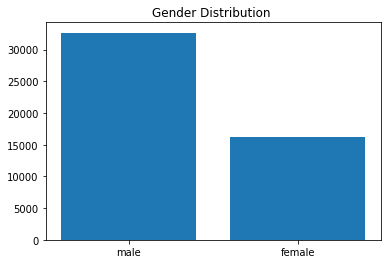

In [5]:
names = ['male', 'female']
values = [len(ad_df[ad_df['sex']==1]), len(ad_df[ad_df['sex']==0])]
plt.bar(names, values)
plt.title("Gender Distribution ") 

Text(0.5, 1.0, 'General Population vs Income')

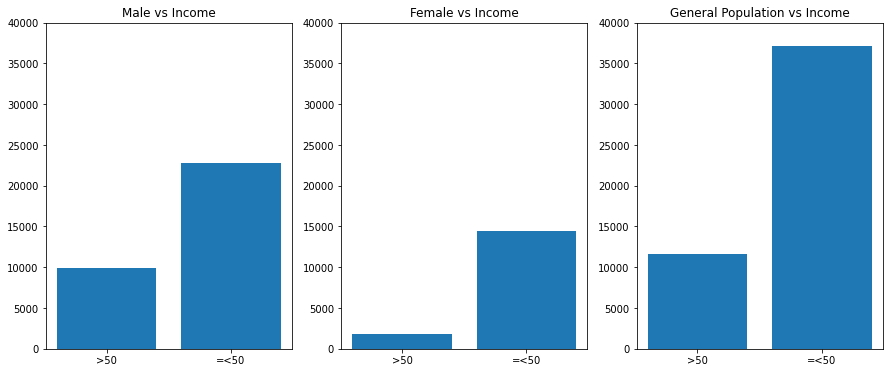

In [6]:
names = ['>50', '=<50']
count = [len(ad_df[ad_df["income-per-year"]==1]), len(ad_df[ad_df["income-per-year"]==0])]
male = ad_df[ad_df['sex']==1]
count_male = [len(male[male["income-per-year"]==1]), len(male[male["income-per-year"]==0])]
female = ad_df[ad_df['sex']==0]
count_female = [len(female[female["income-per-year"]==1]), len(female[female["income-per-year"]==0])]
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].bar(names, count_male)
ax[0].set_ylim(bottom=0, top=40000)
ax[0].set_title("Male vs Income")
ax[1].bar(names, count_female)
ax[1].set_ylim(bottom=0, top=40000)
ax[1].set_title("Female vs Income")
ax[2].bar(names, count)
ax[2].set_ylim(bottom=0, top=40000)
ax[2].set_title("General Population vs Income")

In [7]:
# split the data into train and test set 
ad_train, ad_test = ad.split([0.7], shuffle = True)

In [8]:
ad_train.convert_to_dataframe()[0]

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income-per-year
35782,36.0,13.0,0.0,0.0,0.0,35.0,1.0
3443,39.0,13.0,1.0,0.0,0.0,30.0,0.0
22887,48.0,9.0,1.0,0.0,0.0,40.0,1.0
46168,25.0,9.0,1.0,0.0,0.0,75.0,0.0
19386,46.0,15.0,1.0,99999.0,0.0,50.0,1.0
...,...,...,...,...,...,...,...
5757,30.0,12.0,0.0,0.0,0.0,40.0,0.0
47495,21.0,10.0,0.0,0.0,0.0,20.0,0.0
13691,31.0,12.0,0.0,0.0,0.0,40.0,1.0
30767,27.0,9.0,0.0,0.0,0.0,40.0,0.0


In [9]:
def logistic_classifier( train, test, threshold=0.5):
    """
    Applies logistic regression 
    Args:
        train: Traing set
        test: Test set
        threshold: predict a favourable outcome if probabilty >= threshold
    returns:
        Dataset with predictions from the trained classifier 
    """
    
    # Placeholder for predicted datasets
    orig_train_pred = train.copy(deepcopy=True)
    orig_test_pred = test.copy(deepcopy=True)
    
    # scalling operation
    scale = StandardScaler()
    x_train = scale.fit_transform(train.features)
    y_train = train.labels.ravel()
    
    # logistic regression
    logistic = LogisticRegression()
    logistic.fit(x_train, y_train)
    
    fav_idx = np.where(logistic.classes_ == train.favorable_label)[0][0]
    y_train_pred_prob = logistic.predict_proba(x_train)[:,fav_idx]
    
    x_test = scale.fit_transform(test.features)
    y_test_pred_prob = logistic.predict_proba(x_test)[:, fav_idx]
    
    
    orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
    orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)
    
    y_train_pred = np.zeros_like(orig_train_pred.labels)
    y_train_pred[y_train_pred_prob >= threshold] = orig_train_pred.favorable_label
    y_train_pred[~(y_train_pred_prob >= threshold)] = orig_train_pred.unfavorable_label
    orig_train_pred.labels = y_train_pred
    
    y_test_pred = np.zeros_like(orig_test_pred.labels)
    y_test_pred[y_test_pred_prob >= threshold] = orig_test_pred.favorable_label
    y_test_pred[~(y_test_pred_prob >= threshold)] = orig_test_pred.unfavorable_label
    orig_test_pred.labels = y_test_pred
    
    return orig_train_pred, orig_test_pred

In [10]:
# get the transformed dataset
predicted_train, predicted_test = logistic_classifier(ad_train, ad_test)

# Refresher on the various fairness metrics :

## Equalized odds

A classifier satisfies this definition if the subjects in the protected and unprotected groups have equal TPR and equal FPR.

$$P(\hat{Y} = 1 \vert A = 0 , Y = y ) = P(\hat{Y} = 1 \vert A = 1 , Y = y ) , y \in \{0,1\} $$

## Equal accuracy
 A classifier satisfies this definition if the subject in the protected and unprotected groups have equal prediction accuracy, that is, the probability of a subject from one class to be assigned to it. This is, if it satisfies the following formula
 
$$P(R=Y, A=a ) = P(R=Y, A=b )  \quad \forall  a , b \in A $$ 


## Equal opportunity
We say that a binary predictor ̂Y satisfies equal opportunity with respect to A and Y if

$$P(\hat{Y} = 1 \vert A = 0 , Y = 1 ) = P(\hat{Y} = 1 \vert A = 1 , Y = 1 )  $$


## Treatment equality
A classifier satisfies this definition if the subjects in the protected and unprotected groups have an equal ratio of FN and FP, satisfying the formula

$$\dfrac{FN_{A=a}}{FP_{A=a}} = \dfrac{FN_{A=b}}{FP_{A=b}}$$

## Demographic Parity
 A classifier satisfies this definition if the subjects in the protected and unprotected groups have equal probability of being assigned to the positive predicted class.
 
 $$P(R= + \vert A=a) = P(R= + \vert A=b) \quad \forall a, b \in A    $$
 where R is the predictions and A is the set of groups
 
 [source](https://en.wikipedia.org/wiki/Fairness_(machine_learning))
 
 Further resources:
 https://developers.google.com/machine-learning/glossary/fairness

### Calculate metrics using aif360:

In [11]:
# Class for computing metrics based on two BinaryLabelDatasets using aif360.
cm_pred_train = ClassificationMetric(ad_train, predicted_train,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
cm_pred_test = ClassificationMetric(ad_test, predicted_test,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

In [12]:
# method used to calculate average odds differnce
print(f"Train:",cm_pred_train.average_odds_difference(),"Test:",cm_pred_test.average_odds_difference())

Train: -0.16222849081098398 Test: -0.15543284154491055


### Task 1: Calculate  difference in Equalized odds, Equal accuracy, Equal opportunity, Treatment equality and demographic parity for the predictions.

Assume that sex is a sensitive attribute with sex=1(male) as the privileged groups  and sex=0(female) as the underprivileged  group.
To calculate the metrics you would need to first calculate the confusion matrix. 

In [26]:
def calcualte_metrics(dataset_pred, dataset_true):
    
    metrics = dict()
    
    dataset_pred = dataset_pred.convert_to_dataframe()[0]
    dataset_true = dataset_true.convert_to_dataframe()[0]
    
    # privileged class 
    privileged = 1 
    
    # the previliged group and underprivileged group for the predicted dataset
    dataset_pred_pr = dataset_pred[dataset_pred["sex"] == privileged] 
    dataset_pred_unpr = dataset_pred[~(dataset_pred["sex"] == privileged)]  
 
    # the previliged group and underprivileged group for the ground truth 
    dataset_true_pr = dataset_true[dataset_true["sex"] == privileged]  
    dataset_true_unpr = dataset_true[~(dataset_true["sex"] == privileged)] 
    
    # sanity check ;) 
    # print((len(dataset_pred_pr) + len(dataset_pred_unpr)) == len(dataset_pred) )
    # print(any(dataset_true['income-per-year'] != labels.ravel()))
    
    # previliged metrics
    tn_pr, fp_pr, fn_pr, tp_pr = confusion_matrix(dataset_true_pr['income-per-year'], dataset_pred_pr['income-per-year']).ravel()
       
    # underprevilieged metrics
    tn_unpr, fp_unpr, fn_unpr, tp_unpr = confusion_matrix(dataset_true_unpr['income-per-year'], dataset_pred_unpr['income-per-year']).ravel()
    
    # true positive rate 
    tpr_pr = tp_pr/(tp_pr + fn_pr)
    tpr_unpr = tp_unpr/(tp_unpr + fn_unpr)

    #false positive rate
    fpr_pr = fp_pr/(fp_pr + tn_pr)
    fpr_unpr = fp_unpr/(fp_unpr + tn_unpr)
    
    # accuracy
    acc_pr = (tp_pr + tn_pr)/(tp_pr+fp_pr+fn_pr+tn_pr)
    acc_unpr = (tp_unpr + tn_unpr)/(tp_unpr+fp_unpr+fn_unpr+tn_unpr)

    # difference in equalized_odds
    metrics['equalized_odds'] = ((tpr_pr - tpr_unpr) + (fpr_pr - fpr_unpr))/2
    
    # differnce in accuracy 
    metrics['equalized_accuracy'] = acc_pr -  acc_unpr
    
    # Equal opportunity
    metrics['Equal_opportunity'] = tpr_pr - tpr_unpr
    
    # Treatment equality
    metrics['Treatment_equality'] = fn_pr/fp_pr - fn_unpr/fp_unpr
    
    # print(tn_pr, fp_pr, fn_pr, tp_pr)
    # print(tn_unpr, fp_unpr, fn_unpr, tp_unpr)
    
    # demographic parity 
    metrics['Demographic Parity'] = (tp_unpr + fp_unpr) /  (tn_unpr + fp_unpr + fn_unpr +  tp_unpr) - (tp_pr + fp_pr) /  (tn_pr + fp_pr + fn_pr +  tp_pr)
    
    # dummy_equalized_odds = (tp_pr/fp_pr - tp_unpr/fp_unpr)
    # print(dummy_equalized_odds)
    return metrics

### Task 2.1: Use your function( metrics )  to calculate the metrics for different threshold values. 

In [27]:
all_thresh = np.linspace(0.01, 0.99, 25)
# all_thresh = [0.5]
accuracy = []
eq_odds = []
eq_accuracy = []
eq_oppor = []
Treatment = []
demo_par = []


accuracy_t = []
eq_odds_t = []
eq_accuracy_t = []
eq_oppor_t = []
Treatment_t = []
demo_par_t = []

for threshold in all_thresh:
    # Placeholder for predicted datasets
    orig_train_pred = predicted_train.copy(deepcopy=True)
    orig_test_pred = predicted_test.copy(deepcopy=True)
    
    # update the predicitons based on the new threshold
    y_train_pred = np.zeros_like(orig_train_pred.labels)
    y_train_pred[orig_train_pred.scores.reshape(-1,) >= threshold] = orig_train_pred.favorable_label
    y_train_pred[~(orig_train_pred.scores.reshape(-1,) >= threshold)] = orig_train_pred.unfavorable_label
    orig_train_pred.labels = y_train_pred
                
    # update the predicitons based on the new threshold
    y_test_pred = np.zeros_like(orig_test_pred.labels)
    y_test_pred[orig_test_pred.scores.reshape(-1,) >= threshold] = orig_test_pred.favorable_label
    y_test_pred[~(orig_test_pred.scores.reshape(-1,) >= threshold)] = orig_test_pred.unfavorable_label
    orig_test_pred.labels = y_test_pred
    
    # aif360 used to get the various metrics
    classification_metric_train = ClassificationMetric(ad_train, orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
    
    classification_metric_test = ClassificationMetric(ad_test, orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
    
    # accuary.append(classification_metric_train.accuracy())
    #balanced accuracy 
    accuracy.append(0.5*(classification_metric_train.true_positive_rate()+
                              classification_metric_train.true_negative_rate()))
    accuracy_t.append(0.5*(classification_metric_test.true_positive_rate()+
                              classification_metric_test.true_negative_rate()))
    
    eq_odds.append(classification_metric_train.average_abs_odds_difference())
    eq_odds_t.append(classification_metric_test.average_abs_odds_difference())

    eq_accuracy.append(classification_metric_train.accuracy(True) - classification_metric_train.accuracy(False))
    eq_accuracy_t.append(classification_metric_test.accuracy(True) - classification_metric_test.accuracy(False))
    
    eq_oppor.append(classification_metric_train.true_positive_rate_difference())
    eq_oppor_t.append(classification_metric_test.true_positive_rate_difference())
    
    ratio_pr = classification_metric_train.num_false_negatives(True)/classification_metric_train.num_false_positives(True)
    ratio_unpr = classification_metric_train.num_false_negatives(False)/classification_metric_train.num_false_positives(False)
    Treatment.append(ratio_pr - ratio_unpr)
    
    ratio_pr = classification_metric_test.num_false_negatives(True)/classification_metric_test.num_false_positives(True)
    ratio_unpr = classification_metric_test.num_false_negatives(False)/classification_metric_test.num_false_positives(False)
    Treatment_t.append(ratio_pr - ratio_unpr)
    
#     demo_par.append(classification_metric_train.statistical_parity_difference())
#     demo_par_t.append(classification_metric_test.statistical_parity_difference())

#     metric_train = calcualte_metrics(orig_train_pred, ad_train)
#     metric_test = calcualte_metrics(orig_test_pred, ad_test)

#     eq_odds.append(metric_train['equalized_odds'])
#     eq_accuracy.append(metric_train['equalized_accuracy'])
#     eq_oppor.append(metric_train['Equal_opportunity'])
#     Treatment.append(metric_train['Treatment_equality'])
                       
#     eq_odds_t.append(metric_test['equalized_odds'])
#     eq_accuracy_t.append(metric_test['equalized_accuracy'])
#     eq_oppor_t.append(metric_test['Equal_opportunity'])
#     Treatment_t.append(metric_test['Treatment_equality'])

### Task 2.2: Visualize the variations of the metrics w.r.t. the threshold. Here it would be also important to see how the overall accuracy (consider  *Balanced Accuracy* ) changes as the threshold is varied.

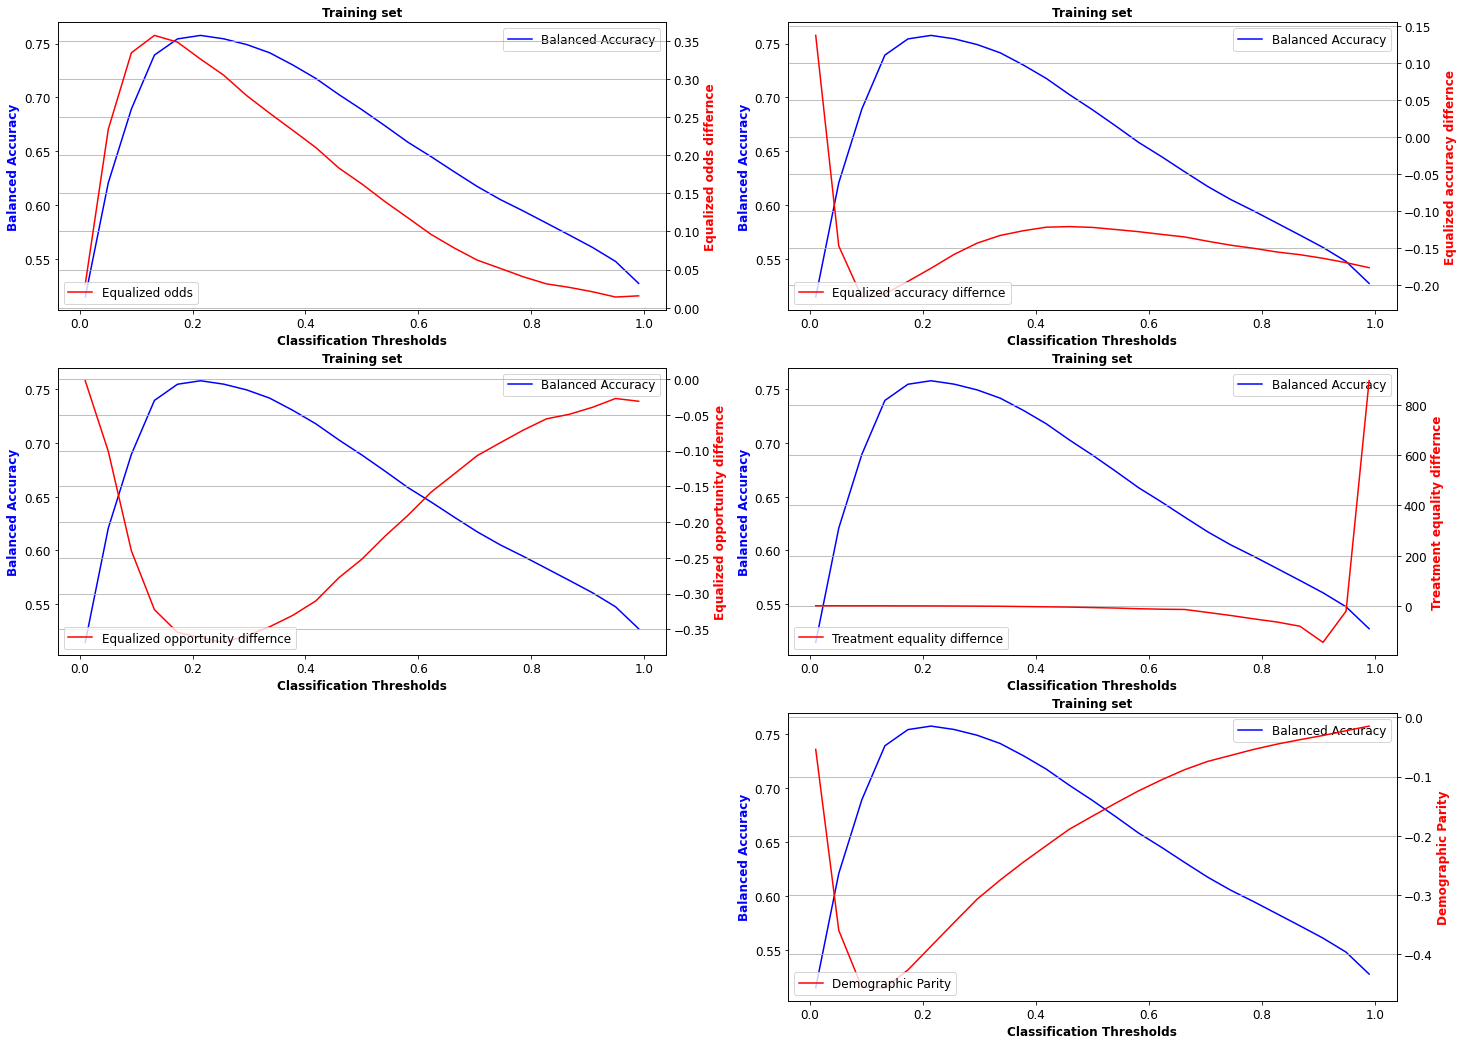

In [15]:
fig, ax = plt.subplots(3,2,figsize=(24,18))

# plot of Balanced accuracy versus threshold
ax[0,0].plot(all_thresh, accuracy, color='b')
ax[0,0].set_title('Training set', fontsize=12, fontweight='bold')
ax[0,0].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
ax[0,0].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
ax[0,0].xaxis.set_tick_params(labelsize=12)
ax[0,0].yaxis.set_tick_params(labelsize=12)
ax[0,0].legend(["Balanced Accuracy"], fontsize=12)

# plot of Equalized odds differnce versus threshold
ax2 = ax[0,0].twinx()
ax2.plot(all_thresh, eq_odds, color='r')
ax2.set_ylabel('Equalized odds differnce', color='r', fontsize=12, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
ax2.legend(["Equalized odds"], fontsize=12, loc="lower left")

# plot of Balanced accuracy versus threshold
ax[0,1].plot(all_thresh, accuracy, color='b')
ax[0,1].set_title('Training set', fontsize=12, fontweight='bold')
ax[0,1].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
ax[0,1].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
ax[0,1].xaxis.set_tick_params(labelsize=12)
ax[0,1].yaxis.set_tick_params(labelsize=12)
ax[0,1].legend(["Balanced Accuracy"], fontsize=12)

# plot of Equalized accuracy differnce versus threshold
ax2 = ax[0,1].twinx()
ax2.plot(all_thresh, eq_accuracy, color='r')
ax2.set_ylabel('Equalized accuracy differnce', color='r', fontsize=12, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
ax2.legend(["Equalized accuracy differnce"], fontsize=12, loc="lower left")

# plot of Balanced accuracy versus threshold
ax[1,0].plot(all_thresh, accuracy, color='b')
ax[1,0].set_title('Training set', fontsize=12, fontweight='bold')
ax[1,0].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
ax[1,0].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
ax[1,0].xaxis.set_tick_params(labelsize=12)
ax[1,0].yaxis.set_tick_params(labelsize=12)
ax[1,0].legend(["Balanced Accuracy"], fontsize=12)

# plot of Equalized opportunity differnce versus threshold
ax2 = ax[1,0].twinx()
ax2.plot(all_thresh, eq_oppor, color='r')
ax2.set_ylabel('Equalized opportunity differnce', color='r', fontsize=12, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
ax2.legend(["Equalized opportunity differnce"], fontsize=12, loc="lower left")

# plot of Balanced accuracy versus threshold
ax[1,1].plot(all_thresh, accuracy, color='b')
ax[1,1].set_title('Training set', fontsize=12, fontweight='bold')
ax[1,1].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
ax[1,1].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
ax[1,1].xaxis.set_tick_params(labelsize=12)
ax[1,1].yaxis.set_tick_params(labelsize=12)
ax[1,1].legend(["Balanced Accuracy"], fontsize=12)

# plot of Treatment equality differnce versus threshold
ax2 = ax[1,1].twinx()
ax2.plot(all_thresh, Treatment, color='r')
ax2.set_ylabel('Treatment equality differnce', color='r', fontsize=12, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
ax2.legend(["Treatment equality differnce"], fontsize=12, loc="lower left")


# plot of Balanced accuracy versus threshold
ax[2,1].plot(all_thresh, accuracy, color='b')
ax[2,1].set_title('Training set', fontsize=12, fontweight='bold')
ax[2,1].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
ax[2,1].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
ax[2,1].xaxis.set_tick_params(labelsize=12)
ax[2,1].yaxis.set_tick_params(labelsize=12)
ax[2,1].legend(["Balanced Accuracy"], fontsize=12)

# plot of Demographic Parity versus threshold
ax2 = ax[2,1].twinx()
ax2.plot(all_thresh, demo_par, color='r')
ax2.set_ylabel('Demographic Parity', color='r', fontsize=12, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
ax2.legend(["Demographic Parity"], fontsize=12, loc="lower left")

fig.delaxes(ax[2][0])

### Task 3: Write a short summary of what you observe from the plots.

Your findings here: *you don't need to code anything for this task, you need to document what information that you get from all your previous analysis*